#Semantic Segmentation of a COCO Subset Using a MobileNetV2–U-Net Model
#Author: Yatish Chandra Sai Udutha
#Student Id: 23030677


In [21]:
# imports & drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, random
from tensorflow import keras
from tensorflow.keras import layers
from pycocotools.coco import COCO
import skimage.io as skio
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from collections import Counter
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Load and prepare data



In [29]:
# Defining paths and create COCO objects
# COCO APIs for train & validation

drive_path = "/content/drive/MyDrive/"

# Paths for training, validation and test splits
path_train = os.path.join(drive_path, "train-300")
path_val   = os.path.join(drive_path, "validation-300")
path_test  = os.path.join(drive_path, "test-30")

# Paths to COCO-style annotation files
ann_train_ = os.path.join(path_train, "labels.json")
ann_val_   = os.path.join(path_val, "labels.json")

# Create COCO API objects for train and validation sets
train_set_coco = COCO(ann_train_)
val_set_coco   = COCO(ann_val_)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [3]:
# Inspect categories and define target classes
# Restrict segmentation to four specific classes

# All categories in training JSON
cat_ID = train_set_coco.getCatIds()
catego = train_set_coco.loadCats(cat_ID)
print("Categories total in JSON:", len(catego))
print("First 5 categories:\n", catego[:5])

# Define target classes
target_class__ = ["person", "cat", "sports ball", "book"]

# Get their COCO IDs
target_class_id_s = train_set_coco.getCatIds(catNms=target_class__)
print("Target_class:", target_class__)
print("Target class IDs:", target_class_id_s)

# Mapping COCO category_id -> our label index (1..4)
# 0 will be reserved for background
id_cat_to_label = {c_id: (i + 1) for i, c_id in enumerate(target_class_id_s)}
print("COCO cat_id -> segmentation label:", id_cat_to_label)


Categories total in JSON: 80
First 5 categories:
 [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]
Target_class: ['person', 'cat', 'sports ball', 'book']
Target class IDs: [1, 17, 37, 84]
COCO cat_id -> segmentation label: {1: 1, 17: 2, 37: 3, 84: 4}


In [4]:
#Collect unique training/validation images that contain at least one target class

def collect_unique_images_with_targets(coco, target_class_id_s):
    """
    Collecting unique image records.

    Parameters
    ----------
    coco_obj : COCO  API object.
    target_class_ids : list[int] Category IDs to filter images by.
    seed : int, optional Random seed used for shuffling the result list.

    Returns
    -------
    list[dict]
        List of unique image-info dictionaries.
    """
    imges = []
    for cat_id in target_class_id_s:
        img_id = coco.getImgIds(catIds=[cat_id])
        imges += coco.loadImgs(img_id)

    # remove duplicates
    uniq_imgs = []
    for img in imges:
        if img not in uniq_imgs:
            uniq_imgs.append(img)

    random.seed(0)
    random.shuffle(uniq_imgs)
    return uniq_imgs

# Build lists of train/validation image metadata restricted to the 4 classes
train_images_info = collect_unique_images_with_targets(train_set_coco, target_class_id_s)
val_images_info   = collect_unique_images_with_targets(val_set_coco, target_class_id_s)

print(f" Unique TRAIN images with at least one target count: {len(train_images_info)}")
print(f"Unique VAL images with at least one target count: {len(val_images_info)}")


 Unique TRAIN images with at least one target count: 300
Unique VAL images with at least one target count: 300


#  Exploratory Data Analysis

1. 300 training, 300 validation and 30 unlabeled test images are taken. Each labelled split includes a COCO-style labels.json file. For this assignment, I restrict the problem to four classes: person, cat, sports ball, and book, plus background.


2. First, I checked the annotation file to compute basic statistics. In Fig.1 instance counts revealed a strong class imbalance, with person dominating the dataset and relatively few examples of cat and especially sports ball. Counting images per class showed that many images contain at least one person, but some classes appear only in a small subset of scenes.


In [5]:
# class frequencies (instances per class) in training set
#instance counts revealed a strong class imbalance, with person dominating
# the dataset and relatively few examples of cat and especially sports ball.
# Counting images per class showed that many images contain at least one person,
#  but some classes appear only in a small subset of scenes.

ann_ids__ = train_set_coco.getAnnIds()
anns_ = train_set_coco.loadAnns(ann_ids__)

instance_counts = Counter()
image_counts    = Counter()

for a in anns_:
    c_id = a["category_id"]
    if c_id in target_class_id_s:
        instance_counts[c_id] += 1
        image_counts[a["image_id"]] += 1

print("Instance counts for target classes:")
for c_id in target_class_id_s:
    c_name = train_set_coco.loadCats([c_id])[0]["name"]
    print(f"{c_name:12s}: {instance_counts[c_id]} instances")




Instance counts for target classes:
person      : 1137 instances
cat         : 27 instances
sports ball : 18 instances
book        : 128 instances


Height – min: 281 max: 640 mean: 477.3666666666667
Width  – min: 333 max: 640 mean: 579.0266666666666


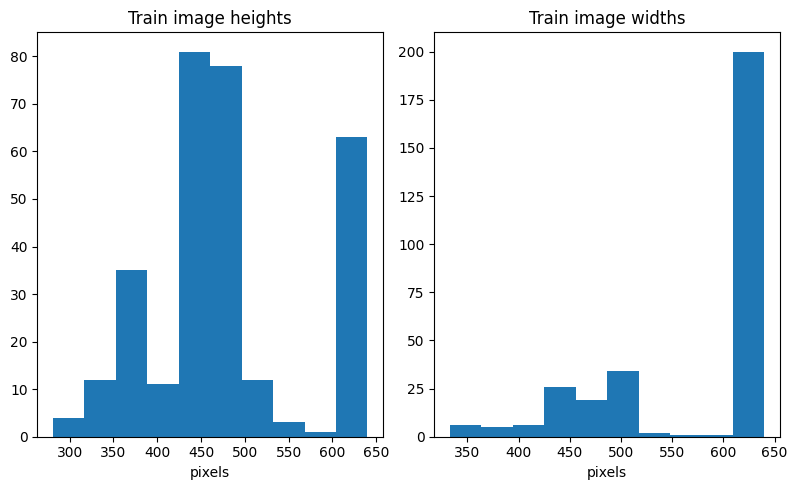

In [6]:
# Image size distribution (train)
#Histograms of image widths and heights indicated moderate variation
# in resolution but with most images in the 480 to 720-pixel range.

tr_heights = [i["height"] for i in train_images_info]
tr_widths  = [i["width"] for i in train_images_info]

print("Height – min:", np.min(tr_heights), "max:", np.max(tr_heights), "mean:", np.mean(tr_heights))
print("Width  – min:", np.min(tr_widths), "max:", np.max(tr_widths), "mean:", np.mean(tr_widths))

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.hist(tr_heights, bins=10) # histogram plot
plt.title("Train image heights") # title
plt.xlabel("pixels")

plt.subplot(1,2,2)
plt.hist(tr_widths, bins=10)  # histogram plot
plt.title("Train image widths")  # Title
plt.xlabel("pixels")
plt.tight_layout()
plt.show()


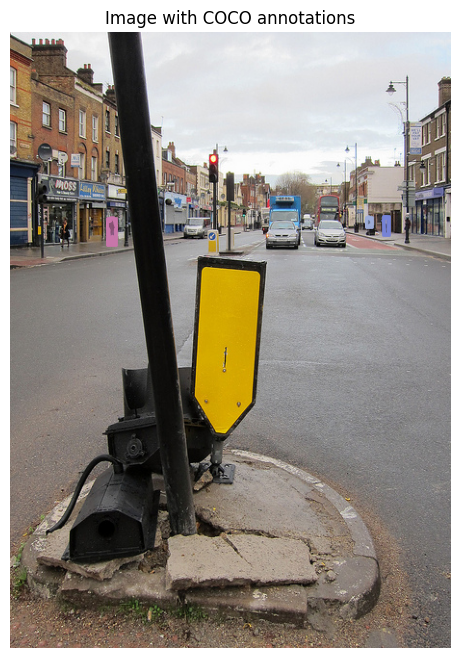

In [7]:
# visualise an example image + its instance masks

def show_example_with_masks(coco, im_info, data_path, target_class_id_s):

    """
    Visualise one image with its COCO annotations.

    Parameters
    ----------
    coco_obj : COCO
        COCO API object.
    img_info : dict
        Image-info dictionary from COCO.
    data_path : str
        Path to folder containing the `data/` subfolder with images.
    target_class_ids : list[int]
        Category IDs to display.
    figsize : tuple, optional
        Figure size passed to matplotlib.
    """

    im_id = im_info["id"]

    image = skio.imread(os.path.join(data_path, "data", im_info["file_name"]))

    ann_ids_ = coco.getAnnIds(imgIds=[im_id], catIds=target_class_id_s, iscrowd=None)
    anns_ = coco.loadAnns(ann_ids_)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    coco.showAnns(anns_, draw_bbox=True)
    plt.axis("off")
    plt.title("Image with COCO annotations")
    plt.show()

example_img_info = train_images_info[0]
show_example_with_masks(train_set_coco, example_img_info, path_train, target_class_id_s)


Shape of Semantic mask : (640, 458)
Uniq labels in_mask: [0 1]


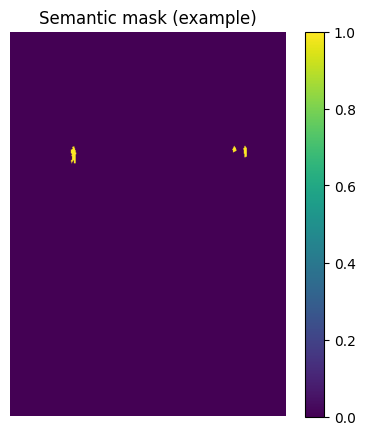

In [8]:
# function to build a semantic mask for one image

def build_semantic_mask_for_image(coco, im_info, target_class_ids, cat_id_to_label):
    """
    Build a 2D semantic mask for a single image by merging all instance masks.

    Parameters
    ----------
    coco_obj : COCO
        COCO API object.
    im_info : dict
        Image-info dictionary from COCO.
    target_class_ids : list[int]
        Category IDs to include in the mask.
    cat_id_to_label : dict[int, int]
        Mapping from COCO category_id to internal label index (1..num_classes-1).
    ignore_crowd : bool, optional
        If True, ignore annotations where iscrowd==1.

    Returns
    -------
    np.ndarray
        Mask of shape (H, W) with integer labels in {0..num_classes-1}
    """
    img_id = im_info["id"]
    ann_ids_ = coco.getAnnIds(imgIds=[img_id], catIds=target_class_ids, iscrowd=None)
    anns_ = coco.loadAnns(ann_ids_)
    mask_ = np.zeros((im_info["height"], im_info["width"]), dtype=np.uint8)

    for a in anns_:
        c_id = a["category_id"]
        if c_id not in target_class_ids:
            continue

        idx_label = cat_id_to_label[c_id]  # 1..4
        ann_mask_ = coco.annToMask(a)      # 0/1 mask of shape (H, W)
        # Assign class label where ann_mask == 1 (later instances overwrite earlier ones)
        mask_[ann_mask_ == 1] = idx_label

    return mask_

# quick check on example
sem_mask = build_semantic_mask_for_image(train_set_coco, example_img_info, target_class_id_s, id_cat_to_label)
print("Shape of Semantic mask :", sem_mask.shape)
print("Uniq labels in_mask:", np.unique(sem_mask))
plt.figure(figsize = (5,5))
plt.imshow(sem_mask, cmap="viridis")
plt.colorbar()
plt.title("Semantic mask (example)")
plt.axis("off")
plt.show()


## Data Generator & Pipeline build

COCO-style annotations are parsed to extract images and instance masks for the four target classes. For each image, individual instance masks are merged into a single semantic mask with integer labels (0 = background, 1–4 = target classes). Images and masks are resized to a fixed 256×256 resolution. Apipeline loads, preprocesses and batches the data: images are normalised with the MobileNetV2 preprocessing function, while masks are kept as integer label maps. Simple augmentations (e.g. random horizontal flip) are applied to improve generalisation.

In [10]:
# data generator and pipeline
#Images and masks are resized to a fixed 256×256 resolution.
#A pipeline loads, preprocesses and batches the data:
#images are normalised with the MobileNetV2 preprocessing function,
# while masks are kept as integer label maps. Simple augmentations
#  (e.g. random horizontal flip) are applied to improve generalisation.

IMG_SIZE__ = 256         # All images or masks resized to 256x256
BATCH_SIZE = 4         # Small batch size due to GPU memory
NUM_CLASSES = len(target_class__) + 1  # 4 foreground + 1 background

def image_mask_generator(images_info_list, coco, data_path, target_class_id_s, id_cat_to_label, img_size):
    """
    Yield (image, mask) pairs as numpy arrays.

    Parameters

    images_info_list : list[dict]
        List of image-info dictionaries.
    coco_obj : COCO
        COCO API object.
    data_path : str
        Path to folder containing the `data/` subfolder with images.
    target_class_ids : list[int]
        Category IDs to include.
    cat_id_to_label : dict[int, int]
        Mapping from COCO category_id to internal label index.
    img_size : int
        Target height/width after resizing.
    preprocess_fn : callable
        Function that preprocesses the image (e.g., MobileNetV2 preprocessor).

    Yields

    image_resized : np.ndarray, float32
        Resized and preprocessed image, shape (img_size, img_size, 3).
    mask_resized : np.ndarray, int32
        Resized mask, shape (img_size, img_size).
    """
    for ig_info in images_info_list:
        file_name = ig_info["file_name"]
        img_path = os.path.join(data_path, "data", file_name)

        # Load img as RGB
        img = skio.imread(img_path)
        if img.ndim == 2:
            # grayscale -> 3 channels
            img = np.stack([img]*3, axis=-1)
        elif img.shape[2] == 4:
            # RGBA -> RGB
            img = img[:, :, :3]

        mask = build_semantic_mask_for_image(coco, ig_info, target_class_id_s, id_cat_to_label)

        # Resize image and mask
        image_resized = tf.image.resize(img, (img_size, img_size)).numpy().astype(np.float32)
        mask_resized = tf.image.resize(np.expand_dims(mask, axis=-1),
            (img_size, img_size), method="nearest").numpy().astype(np.int32)
        mask_resized = np.squeeze(mask_resized, axis=-1)

        # Preprocess image for MobileNetV2 (-1..1)
        image_resized = mobilenet_preprocess(image_resized)

        yield image_resized, mask_resized

output_signature = (
    tf.TensorSpec(shape=(IMG_SIZE__, IMG_SIZE__, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(IMG_SIZE__, IMG_SIZE__), dtype=tf.int32),
)

def make_dataset(images_info_list, coco, data_path, shuffle=True):
    ds = tf.data.Dataset.from_generator(
        lambda: image_mask_generator(
            images_info_list, coco, data_path, target_class_id_s, id_cat_to_label, IMG_SIZE__
        ),
        output_signature=output_signature,
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=64, reshuffle_each_iteration=False, seed = 23030677)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds




In [11]:
train_ds = make_dataset(train_images_info, train_set_coco, path_train, shuffle=True)
val_ds   = make_dataset(val_images_info, val_set_coco, path_val, shuffle=False)

for batch_imag, batch_mask in train_ds.take(1):
    print("Batch image shape:", batch_imag.shape)
    print("Batch mask shape:", batch_mask.shape)

Batch image shape: (4, 256, 256, 3)
Batch mask shape: (4, 256, 256)


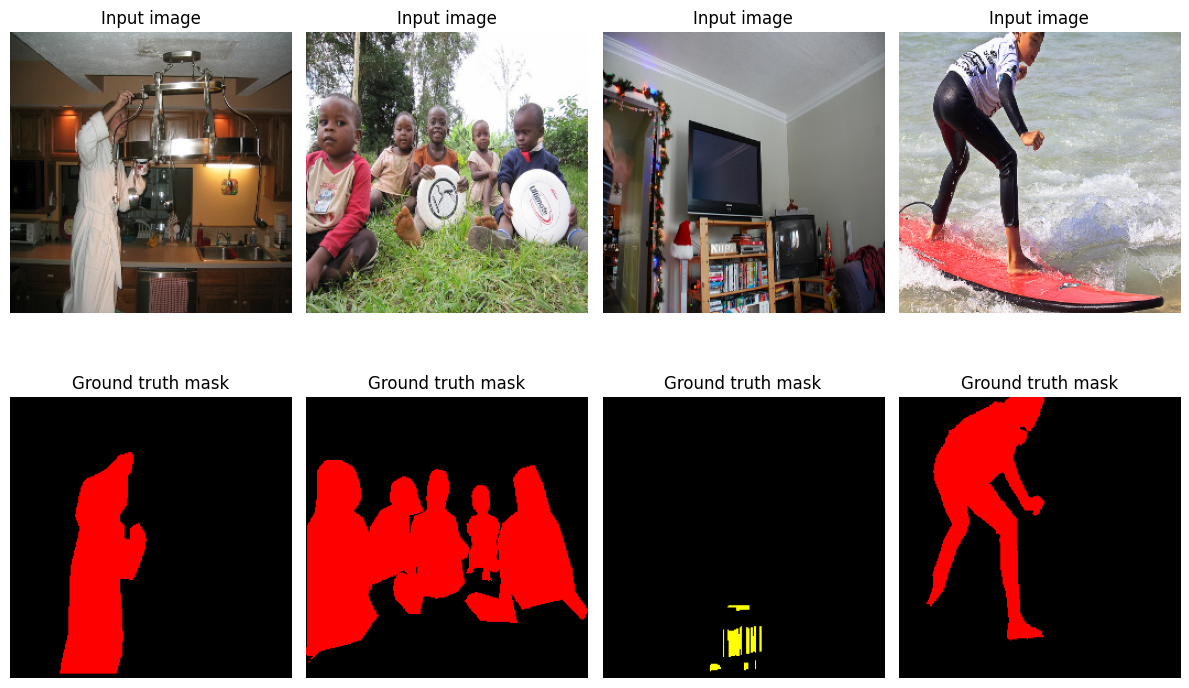

In [12]:
#visualisation of batch (image & mask)
# colour map for 5 classes (background + 4)
#I highlighted small objects (balls, books) and cluttered scenes with multiple
# examined the distribution of object areas (in pixels) and visualised a sample
# of images with their segmentation masks covered. The people and blockings,
#suggesting that both class imbalance and object scale would challenge model.

COLORS = np.array([
    [0, 0, 0],        # background - black
    [255, 0, 0],      # person - red
    [0, 255, 0],      # cat - green
    [0, 0, 255],      # sports ball - blue
    [255, 255, 0],], dtype=np.uint8)# book - yellow

def decode_mobilenet_image(x):
    # inverse of preprocess_input: from [-1,1] to [0,1]
    return (x + 1.0) / 2.0

def colorize_mask(mask):
    # mask: (H, W) with ints 0..4
    """
    Convert an integer label mask into an RGB colour mask.

    Parameters
    ----------
    mask : np.ndarray, shape (H, W)
    num_classes : int
    colors : np.ndarray, shape (num_classes, 3)

    Returns
    -------
    np.ndarray, shape (H, W, 3)
    """

    h,w = mask.shape
    color_mask = np.zeros((h,w,3), dtype=np.uint8)
    for cls_idx in range(NUM_CLASSES):
        color_mask[mask == cls_idx] = COLORS[cls_idx]
    return color_mask

batch_images, batch_masks = next(iter(train_ds))

plt.figure(figsize=(12, 8))
for i in range(min(BATCH_SIZE, 4)):
    img = decode_mobilenet_image(batch_images[i].numpy())
    mask = batch_masks[i].numpy()

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input image")

    plt.subplot(2, 4, i+5)
    plt.imshow(colorize_mask(mask))
    plt.axis("off")
    plt.title("Ground truth mask")
plt.tight_layout()
plt.show()


# Model Building
I took a U-Net–style encoder–decoder implemented in TensorFlow/Keras. The encoder reuses a pre-trained MobileNetV2 backbone (ImageNet weights), from which several intermediate feature maps are tapped for skip connections. A series of transposed convolution blocks gradually up-samples the bottleneck features, concatenating them with encoder features at matching resolutions. The final 1×1 convolution outputs per-pixel logits over five classes.

In [13]:
#  U-Net style model with MobileNetV2 backbone
#The encoder reuses a pre-trained MobileNetV2 backbone (ImageNet weights),
#from which several intermediate feature maps are tapped for skip connections.

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE__, IMG_SIZE__, 3),include_top=False,weights="imagenet")

# Use these layers' outputs for skip connections
layer_names = [
    "block_1_expand_relu",   # 128x128
    "block_3_expand_relu",   # 64x64
    "block_6_expand_relu",   # 32x32
    "block_13_expand_relu",  # 16x16
    "block_16_project",      # 8x8
]

layers_outputs = [base_model.get_layer(name).output for name in layer_names]
down__stack = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)
down__stack.trainable = False  # start with frozen encoder

/tmp/ipython-input-2866682427.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [14]:

def up__sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    res = tf.keras.Sequential()
    res.add(
        layers.Conv2DTranspose(filters,size,strides=2,padding="same",
            kernel_initializer=initializer,use_bias=False))
    res.add(layers.BatchNormalization())
    res.add(layers.ReLU())
    if apply_dropout:
        res.add(layers.Dropout(0.5))
    return res

up__stack = [
    up__sample(512, 3),  # 8x8  -> 16x16
    up__sample(256, 3),  # 16x16-> 32x32
    up__sample(128, 3),  # 32x32-> 64x64
    up__sample(64, 3),   # 64x64->128x128
]

def model_UNET(output_channels):
    inputs = layers.Input(shape=(IMG_SIZE__, IMG_SIZE__, 3))

    # Down-sampling through the model
    skip = down__stack(inputs)
    x = skip[-1]        # bottleneck
    skip = reversed(skip[:-1])

    # Up-sampling and skip connections
    for up, s in zip(up__stack, skip):
        x = up(x)
        x = layers.Concatenate()([x, s])

    # Last upsample to get back to IMG_SIZE
    last = layers.Conv2DTranspose(
        output_channels,
        3,
        strides=2,
        padding="same",
    )  # no activation -> logits

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

model = model_UNET(NUM_CLASSES)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 128, 128, │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16, 16,    │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64, 64,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 128, 128,  │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 256, 256,  │      7,205 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 5)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,507,109 (24.82 MB)

 Trainable params: 4,663,205 (17.79 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [15]:
# compile model
# The model is trained with Sparse Categorical Cross-Entropy and Adam-optimiser.
# Early stopping based on validation loss reduces overfitting.
#During training, track loss and sparse categorical accuracy, after training,
# compute per-class Intersection-over-Union(IoU) on validation set and
# perform qualitative analysis on validation and test images.

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=["sparse_categorical_accuracy"],
)

EPOCHS = 20

# callbacks: early stopping & best model checkpoint
checkpoint_path = "/content/drive/MyDrive/best_segmentation_model.h5"

callbacks__ = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
]

history__ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks__,
)


Epoch 1/20
     74/Unknown 38s 110ms/step - loss: 1.2690 - sparse_categorical_accuracy: 0.4888

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.56898, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 332ms/step - loss: 1.2603 - sparse_categorical_accuracy: 0.4934 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.8342
Epoch 2/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.4655 - sparse_categorical_accuracy: 0.8619

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.56898 to 0.40596, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - loss: 0.4651 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.8643
Epoch 3/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.8829

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_loss improved from 0.40596 to 0.34578, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8828 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.8837
Epoch 4/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3206 - sparse_categorical_accuracy: 0.8951

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss improved from 0.34578 to 0.31599, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.3160 - val_sparse_categorical_accuracy: 0.8957
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2935 - sparse_categorical_accuracy: 0.9044

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss improved from 0.31599 to 0.29981, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - loss: 0.2936 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.2998 - val_sparse_categorical_accuracy: 0.9023
Epoch 6/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2697 - sparse_categorical_accuracy: 0.9133

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_loss improved from 0.29981 to 0.29119, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - loss: 0.2699 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.2912 - val_sparse_categorical_accuracy: 0.9051
Epoch 7/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2466 - sparse_categorical_accuracy: 0.9217

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 7: val_loss improved from 0.29119 to 0.28048, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - loss: 0.2468 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.2805 - val_sparse_categorical_accuracy: 0.9081
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9296

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_loss improved from 0.28048 to 0.27737, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 359ms/step - loss: 0.2248 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.2774 - val_sparse_categorical_accuracy: 0.9084
Epoch 9/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2035 - sparse_categorical_accuracy: 0.9375

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_loss improved from 0.27737 to 0.27665, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.2766 - val_sparse_categorical_accuracy: 0.9090
Epoch 10/20
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9440

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_loss improved from 0.27665 to 0.27159, saving model to /content/drive/MyDrive/Individual assignment 2/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9439 - val_loss: 0.2716 - val_sparse_categorical_accuracy: 0.9113
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9453

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 11: val_loss did not improve from 0.27159
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - loss: 0.1785 - sparse_categorical_accuracy: 0.9453 - val_loss: 0.3032 - val_sparse_categorical_accuracy: 0.9055
Epoch 12/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9468

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_loss did not improve from 0.27159
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.2955 - val_sparse_categorical_accuracy: 0.9079
Epoch 13/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9535

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 13: val_loss did not improve from 0.27159
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.2863 - val_sparse_categorical_accuracy: 0.9114
Epoch 14/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1441 - sparse_categorical_accuracy: 0.9571

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_loss did not improve from 0.27159
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - loss: 0.1441 - sparse_categorical_accuracy: 0.9571 - val_loss: 0.3043 - val_sparse_categorical_accuracy: 0.9089
Epoch 15/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9604

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 15: val_loss did not improve from 0.27159
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.3585 - val_sparse_categorical_accuracy: 0.8972
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


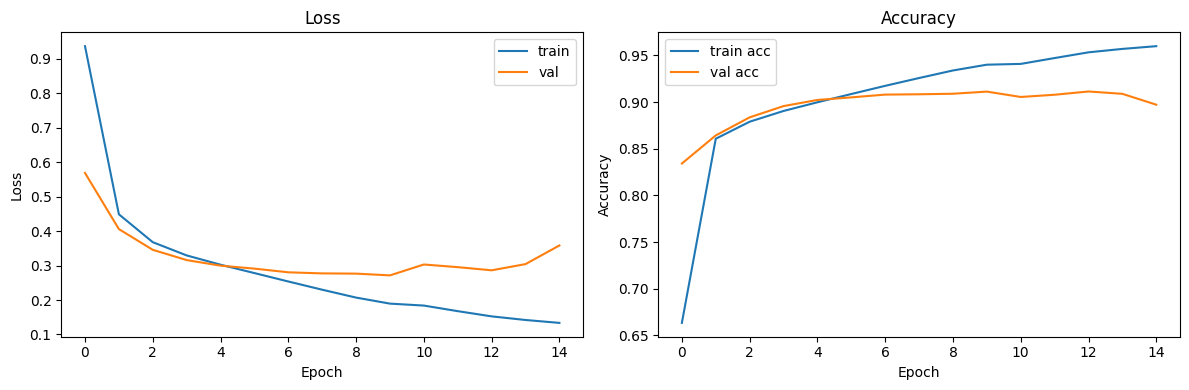

In [16]:
# Plot training and validation loss / accuracy
#training loss decreases to ~0.12, while validation loss stays around 0.3.
# Training accuracy continues to rise and validation accuracy stabilises at 0.9,
# showing little overfitting. This is expected given the small dataset and
#frozen encoder: the decoder learns class-specific refinements
# while the pre-trained backbone provides stable features.

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history__.history["loss"], label="train")
plt.plot(history__.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history__.history["sparse_categorical_accuracy"], label="train acc")
plt.plot(history__.history["val_sparse_categorical_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()


In [17]:
# compute IoU per class on validation set
#Per-class IoU on the validation set reveals a strong dependence on data
#distribution. The model performs better for background and person classes,
# reflecting that these pixels dominate both images and annotations.
# Cat reaches 0.42, which is better, considering the limited number of examples
# and the network sometimes confuses cat pixels with background. Sports ball and
# book have 0.00 IoU, meaning that predicted masks never overlap substantially
#with ground truth, the model effectively collapses these classes into
# background or person, consistent with the class-imbalance.

def compute_iou_per_class(model, dataset, num_classes):
    ious = {cls_id_: {"inter": 0, "union": 0} for cls_id_ in range(num_classes)}

    for imgs__batch, masks__batch in dataset:
        logits_ = model.predict(imgs__batch, verbose=0)
        preds_ = np.argmax(logits_, axis=-1).astype(np.int32)  # (B,H,W)

        true_masks = masks__batch.numpy()

        for cls_id_ in range(num_classes):
            # ignore background IoU if you prefer (cls_id_ == 0)
            pred_cls_ = (preds_ == cls_id_)
            true_cls_ = (true_masks == cls_id_)

            #intersction = np.logical_and(pred_cls, true_cls).sum()
            #unio = np.logical_or(pred_cls, true_cls).sum()

            ious[cls_id_]["inter"] += np.logical_and(pred_cls_, true_cls_).sum()
            ious[cls_id_]["union"] += np.logical_or(pred_cls_, true_cls_).sum()

    iou_scores = {}
    for cls_id_ in range(num_classes):
        inter = ious[cls_id_]["inter"]
        union = ious[cls_id_]["union"]
        if union == 0:
            iou = np.nan
        else:
            iou = inter / union
        iou_scores[cls_id_] = iou

    return iou_scores

iou_scores = compute_iou_per_class(model, val_ds, NUM_CLASSES)

print("Per-class IoU (0 = background):")
for cls_id_, iou in iou_scores.items():
    if cls_id_ == 0:
        cls_name_ = "background"
    else:
        cls_name_ = target_class__[cls_id_ - 1]
    print(f"{cls_id_} ({cls_name_:12s}): {iou:.4f}")


Per-class IoU (0 = background):
0 (background  ): 0.9056
1 (person      ): 0.5706
2 (cat         ): 0.2371
3 (sports ball ): 0.0000
4 (book        ): 0.0000


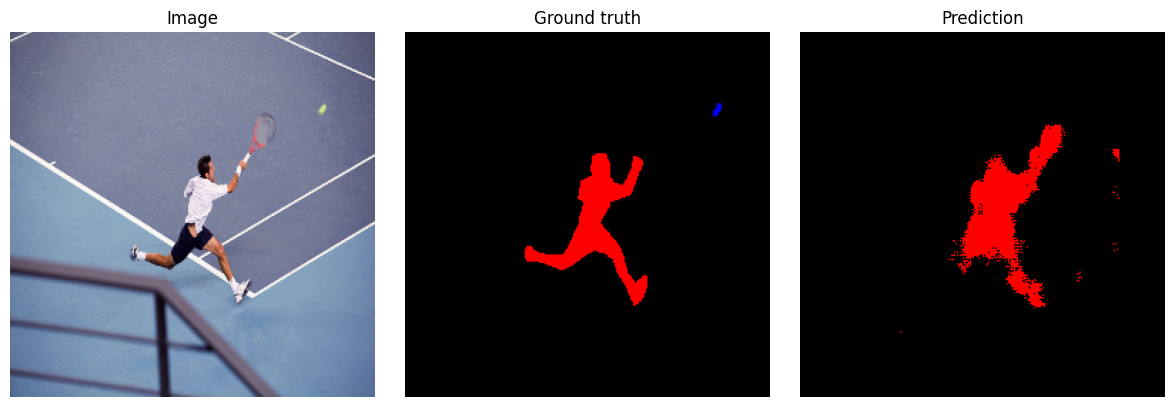

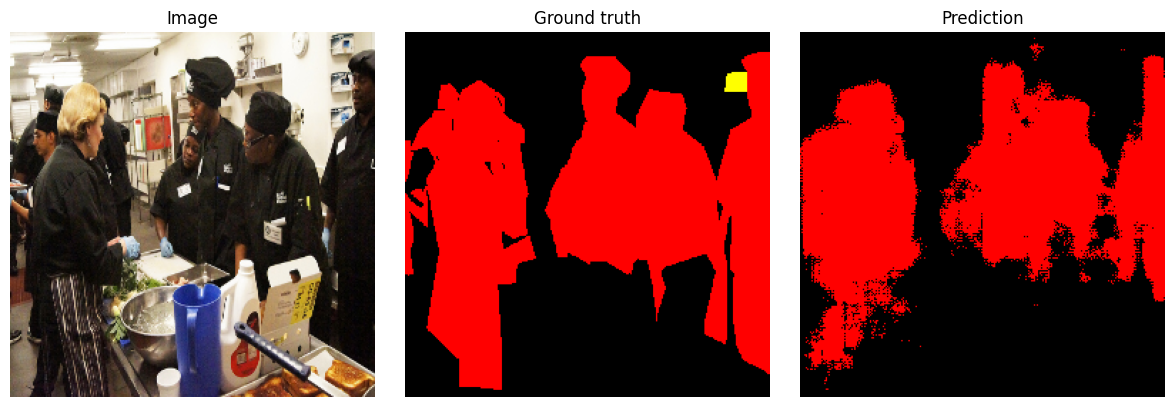

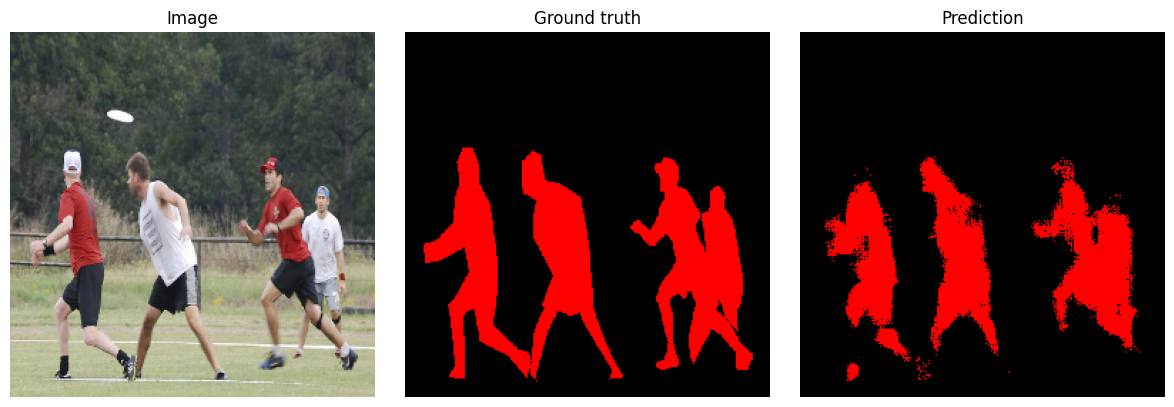

In [18]:
# Show predictions vs ground truth for some validation samples
#In the tennis image, the player is roughly segmented, but the mask is noisy
# and misses limbs and the racket. In the crowded kitchen scene, nearly
#all people are detected but merged into thick blobs with over-smoothed
#boundaries, illustrating the limitation of treating an instance problem
#as pure semantic segmentation.

def show_predictions(dataset, model, num_samples=3):
    for img__batch, mask__batch in dataset.take(1):
        logits_ = model.predict(img__batch, verbose=0)
        preds_ = np.argmax(logits_, axis=-1)

        for i in range(num_samples):
            img = decode_mobilenet_image(img__batch[i].numpy())
            tru__mask = mask__batch[i].numpy()
            pred__mask = preds_[i]

            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.imshow(img)
            plt.axis("off")
            plt.title("Image")

            plt.subplot(1,3,2)
            plt.imshow(colorize_mask(tru__mask))
            plt.axis("off")
            plt.title("Ground truth")

            plt.subplot(1,3,3)
            plt.imshow(colorize_mask(pred__mask))
            plt.axis("off")
            plt.title("Prediction")

            plt.tight_layout()
            plt.show()

show_predictions(val_ds, model, num_samples=3)


# Working on test data

In [19]:
#Test dataset (no labels), predictions + visualisation

def test_imgs_load(test_path):
    imags_ = []
    filenames_ = []
    data_folder_ = os.path.join(test_path)
    for f in sorted(os.listdir(data_folder_)):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(data_folder_, f)
            img = skio.imread(img_path)
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[2] == 4:
                img = img[:, :, :3]
            imags_.append(img)
            filenames_.append(f)
    return imags_, filenames_

test_images_, test_filenames_ = test_imgs_load(path_test)
print("Number of test images:", len(test_images_))


Number of test images: 30


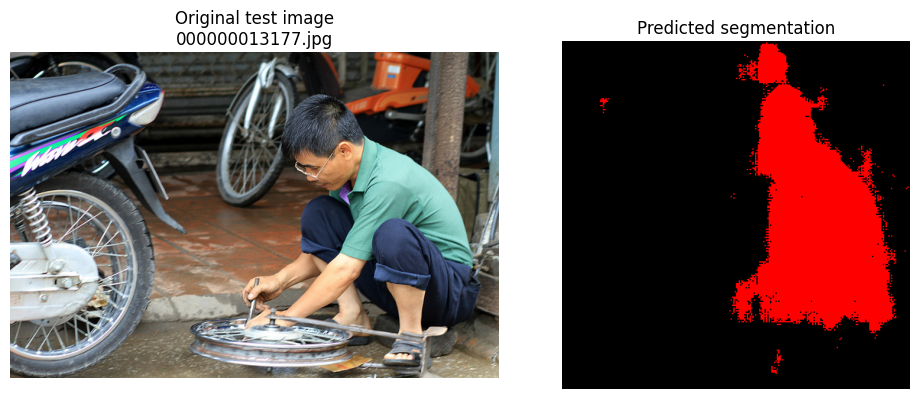

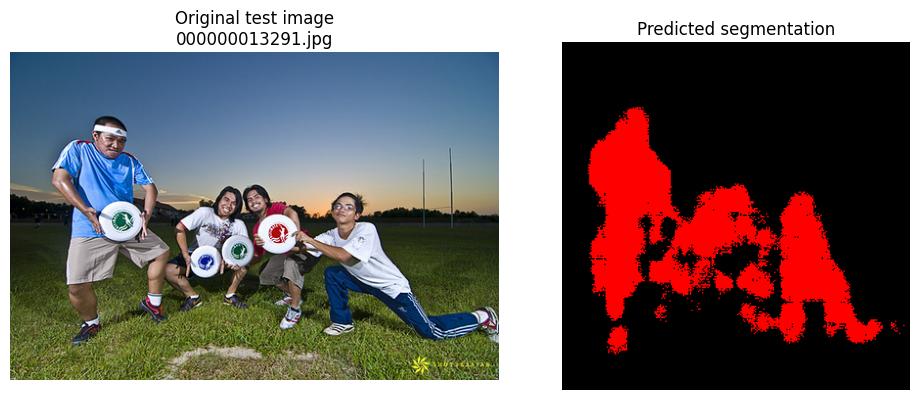

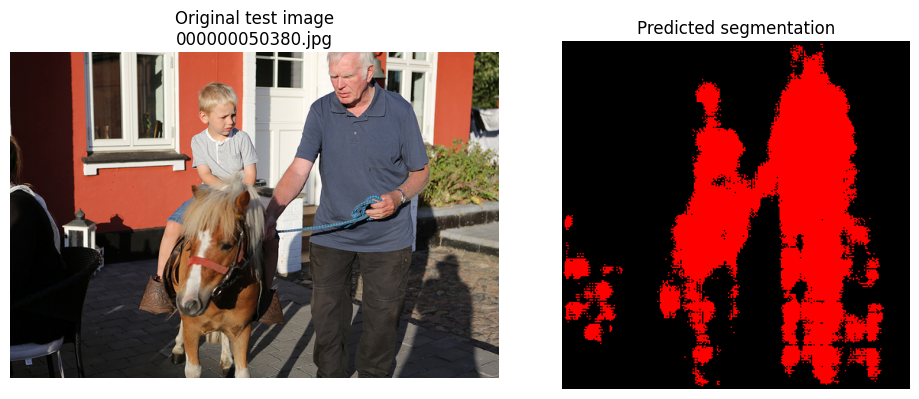

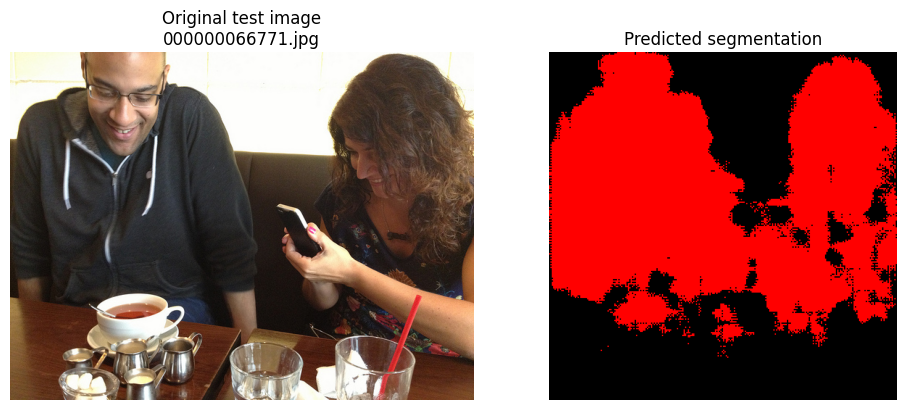

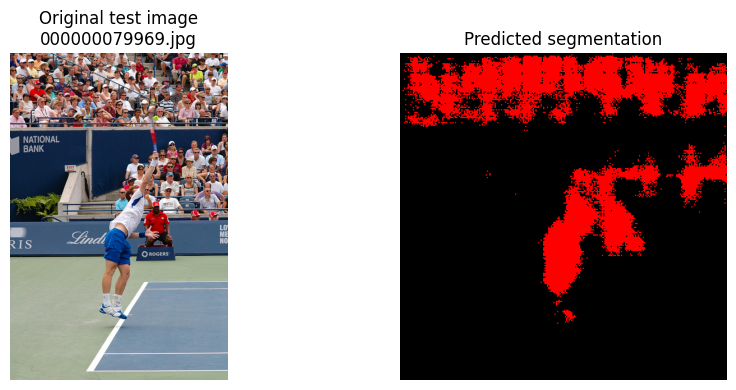

In [20]:
#Run model on a few testing images and visualise

def predict_and_show_on_test(model, images, filenames, num_samples=5):
    num_samples_ = min(num_samples, len(images))
    for i in range(num_samples_):
        img = images[i]
        fname = filenames[i]

        # resize & preprocess
        img_resized = tf.image.resize(img, (IMG_SIZE__, IMG_SIZE__)).numpy().astype(np.float32)
        img_preproc = mobilenet_preprocess(img_resized)
        logits = model.predict(np.expand_dims(img_preproc, axis=0), verbose=0)
        pred_mask = np.argmax(logits[0], axis=-1)

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Original test image\n{fname}")

        plt.subplot(1,2,2)
        plt.imshow(colorize_mask(pred_mask))
        plt.axis("off")
        plt.title("Predicted segmentation")
        plt.tight_layout()
        plt.show()

predict_and_show_on_test(model, test_images_, test_filenames_, num_samples=5)


#Results:
1. The network successfully highlights the main people in the scene, but produces rough outlines that ignore fine details and fail to capture non-person objects. This indicates reasonable generalisation to new images for the majority class but very poor transfer for minority classes.

2. Overall, the model performs well when objects are large and frequent, but struggles with small or under-represented categories and cannot distinguish individual instances. Addressing these issues would require more balanced data, stronger augmentation targeting small objects, loss re-weighting, or moving towards a true instance-segmentation architecture such as Mask R-CNN.